## Environment Preparation

* Load the SDK code from the local package directory
* Load the API key and secret in the .env file

In [1]:
# Quick hack to load local SDK code
import os

os.chdir(os.path.join(os.getcwd(), ".."))

# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

True

## ValidMind SDK Introduction

In [2]:
import pandas as pd
import xgboost as xgb

from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

%matplotlib inline

## Initializing the ValidMind SDK

After creating an account with ValidMind, we can find the project's API key and secret in the settings page of the ValidMind dashboard:

<img src="https://vmai.s3.us-west-1.amazonaws.com/sdk-images/settings.png" width="600" height="300" />

The SDK credentials can be configured in two ways:

- By setting the `VM_API_KEY` and `VM_API_SECRET` environment variables or
- By passing `api_key` and `api_secret` arguments to the `init` function like this:

```python
vm.init(
    api_key='<your-api-key>',
    api_secret='<your-api-secret>',
    project="cl2r3k1ri000009jweny7ba1g"
)
```

The `project` argument is mandatory since it allows the SDK to associate all data collected with a specific account project.

In [3]:
import validmind as vm

# For test environment use api_host="https://api.test.vm.validmind.ai/api/v1/tracking"
vm.init(project="cl2r3k1ri000009jweny7ba1g")

True

### Using a demo dataset

For this simple demonstration, we will use the following bank customer churn dataset from Kaggle: https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction/data.

We will train a sample model and demonstrate the following ValidMind SDK functionalities:

- Logging information about a dataset
- Running data quality tests on a dataset
- Logging information about a model
- Logging training metrics for a model
- Running model evaluation tests

Before we logging any data on a new project, the ValidMind dashboard will let users know that they can automatically populate the different documentation sections by integrating the ValidMind into a model development environment:

<img src="https://vmai.s3.us-west-1.amazonaws.com/sdk-images/empty-data-description.png" width="600" height="300">

#### Logging general project metadata with `log_metadata`

The ValidMind SDK provides a function to log free-form metadata for a project. A list of preconfigured `content_id` can be used to select where in the dashboard documentation we want this metadata to be displayed. As an example, if a model developer wants to populate the `Model Overview` section for a project, they can use `model_overview` as the `content_id`:

```python
vm.log_dataset("model_overview", text="Testing")
```

The `text` argument accepts Markdown formatted text as we'll see in the cell below. The documentation used for this model has been taken from the [Kaggle dataset](https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction/data).

In [4]:
model_overview = """
We aim to accomplish the following for this study:

- Identify and visualize which factors contribute to customer churn
- Build a prediction model that will perform the following:
  - Classify if a customer is going to churn or not
  - Preferably and based on model performance, choose a model that will attach a probability
  to the churn to make it easier for customer service to target low hanging fruits in their
  efforts to prevent churn
"""

vm.log_metadata(content_id="model_overview", text=model_overview)

Successfully logged metadata


True

The dashboard should now display the `Model Overview` section with the text we have provided from the SDK:

<img src="https://vmai.s3.us-west-1.amazonaws.com/sdk-images/model-overview.png" width="600" height="300">

#### Logging information about a dataset with `log_dataset`

The `log_dataset` SDK function will collect the following metadata about the given dataset:

- Field types and descriptions
- Descriptive statistics
- Data distribution histograms
- Feature correlation

In [5]:
df = pd.read_csv("notebooks/datasets/bank_customer_churn.csv")

targets = vm.DatasetTargets(
    target_column="Exited",
    class_labels={
        "0": "Did not exit",
        "1": "Exited",
    }
)

features = [
    {
        "id": "RowNumber",
        "type_options": {
            "primary_key": True,
        }
    }
]

vm_dataset = vm.log_dataset(df, "training", targets=targets, features=features)

#### Running data quality tests with `run_dataset_tests`

When using `run_dataset_tests`, the SDK will compute some basic quality metrics on the dataset and evaluate if they are within expected ranges as configured by ValidMind and model validators.

In [6]:
results = vm.run_dataset_tests(
    df,
    dataset_type="training",
    vm_dataset=vm_dataset,    
    send=True,
)

Running data quality tests for "training" dataset...

Preparing dataset for tests...


100%|██████████| 6/6 [00:00<00:00, 43.55it/s]


Test suite has completed.
Sending results to ValidMind...


Successfully logged test results for test: class_imbalance
Successfully logged test results for test: duplicates
Successfully logged test results for test: cardinality
Successfully logged test results for test: missing
Successfully logged test results for test: skewness
Successfully logged test results for test: zeros

Summary of results:

Test             Passed      # Passed    # Errors    % Passed
---------------  --------  ----------  ----------  ----------
class_imbalance  True               1           0         100
duplicates       True               2           0         100
cardinality      False              6           1     85.7143
missing          True              14           0         100
skewness         False              6           1     85.7143
zeros            False              0           2           0



We can now see all dataset related metadata and data quality metrics in the ValidMind dashboard:

<img src="https://vmai.s3.us-west-1.amazonaws.com/sdk-images/data-description.png" width="600" height="300">

### Preparing the dataset for training

Before we train a model, we need to run some common minimal feature selection and engineering steps on the dataset:

- Dropping irrelevant variables
- Encoding categorical variables

#### Dropping irrelevant variables

The following variables will be dropped from the dataset:

- `RowNumber`: it's a unique identifier to the record
- `CustomerId`: it's a unique identifier to the customer
- `Surname`: no predictive power for this variable
- `CreditScore`: we didn't observer any correlation between `CreditScore` and our target column `Exited`

In [7]:
df.drop(["RowNumber", "CustomerId", "Surname", "CreditScore"], axis=1, inplace=True)

#### Encoding categorical variables

We will apply one-hot or dummy encoding to the following variables:

- `Geography`: only 3 unique values found in the dataset
- `Gender`: convert from string to integer

In [8]:
genders = {"Male": 0, "Female": 1}
df.replace({"Gender": genders}, inplace=True)

In [9]:
df = pd.concat([df, pd.get_dummies(df["Geography"], prefix="Geography")], axis=1)
df.drop("Geography", axis=1, inplace=True)

We are now ready to train our model with the preprocessed dataset:

In [10]:
df.head()

,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


#### Dataset preparation

For training our model, we will **randomly** split the dataset in 3 parts:

- `training` split with 60% of the rows
- `validation` split with 20% of the rows
- `test` split with 20% of the rows

The `test` dataset will be our held out dataset for model evaluation.

In [11]:
train_df, test_df = train_test_split(df, test_size=0.20)

# This guarantees a 60/20/20 split
train_ds, val_ds = train_test_split(train_df, test_size=0.25)

# For training
x_train = train_ds.drop("Exited", axis=1)
y_train = train_ds.loc[:, "Exited"].astype(int)
x_val = val_ds.drop("Exited", axis=1)
y_val = val_ds.loc[:, "Exited"].astype(int)

# For testing
x_test = test_df.drop("Exited", axis=1)
y_test = test_df.loc[:, "Exited"].astype(int)

### Model training

We will train a simple XGBoost model and set its `eval_set` to `[(x_train, y_train), (x_val, y_val)]` in order to collect validation datasets metrics on every round. The ValidMind SDK supports collecting any type of "in training" metrics so model developers can provide additional context to model validators if necessary.

In [12]:
xgb_model = xgb.XGBClassifier(early_stopping_rounds=10)
xgb_model.set_params(
    eval_metric=["error", "logloss", "auc"],
)
xgb_model.fit(
    x_train,
    y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    verbose=False,
)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['error', 'logloss', 'auc'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [13]:
vm.log_training_metrics(xgb_model, x_train, y_train, x_val, y_val)

Successfully logged metrics


True

In [14]:
y_pred = xgb_model.predict_proba(x_val)[:, -1]
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_val, predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.776875


#### Logging model metadata with `log_model`

The `log_model` SDK function allows sending the following model metadata to the API:

- Model framework and architecture (e.g. XGBoost, Random Forest, Logistic Regression, etc.)
- Model task details (e.g. binary classification, regression, etc.)
- Model hyperparameters (e.g. number of trees, max depth, etc.)

In [15]:
vm.log_model(xgb_model)

True

#### Logging model training metrics with `log_training_metrics`

The SDK can automatically collect metrics that were captured by the framework during model training. The following are some example metrics that can be collected:

- AUC
- Error rate
- Logloss
- Feature importance

When the framework has generated one metric value on each iteration/round, the SDK will collect all of the iteration values and group them appropriately.

In [16]:
vm.log_training_metrics(xgb_model, x_train, y_train, x_val, y_val)

Successfully logged metrics


True

### Running model evaluation tests with `evaluate_model`

When using `evaluate_model`, the SDK will run the appropriate model evaluation tests according to the following criteria:

- Model use case
- Model objective
- Validation requirements set by the model validator

In [17]:
# Find an optimal threshold for the model before we evaluate it
# We want to focus on a threshold that maximizes the F1 score since
# we are interested in optimizing performance for the minority class
y_pred = xgb_model.predict_proba(x_val)[:, -1]

precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
fscore = (2 * precision * recall) / (precision + recall)
# Get the index of the largest F1 Score
ix = argmax(fscore)
threshold = thresholds[ix]
print('Optimal threshold=%f, F1 Score=%.3f' % (threshold, fscore[ix]))

Optimal threshold=0.045254, F1 Score=0.346


In [23]:
threshold_metric = vm.Metric(
    type="evaluation",
    scope="test",
    key="decision_threshold",
    value=[threshold]
)

vm.log_metrics([threshold_metric])

Successfully logged metrics


True

Generating model predictions on test dataset...
Using custom decision threshold for evaluation: 0.045254163444042206
Generating model predictions on training dataset...
Computing model evaluation metrics...


100%|██████████| 10/10 [00:00<00:00, 25.97it/s]


Sending 10 metrics results to ValidMind...
Successfully logged metrics
Sending 2 figures to ValidMind...

Summary of metrics:

Metric        Value
---------  --------
accuracy   0.428125
f1_score   0.415335
precision  0.263585
recall     0.978916
roc_auc    0.631414

Plotting model evaluation metrics...


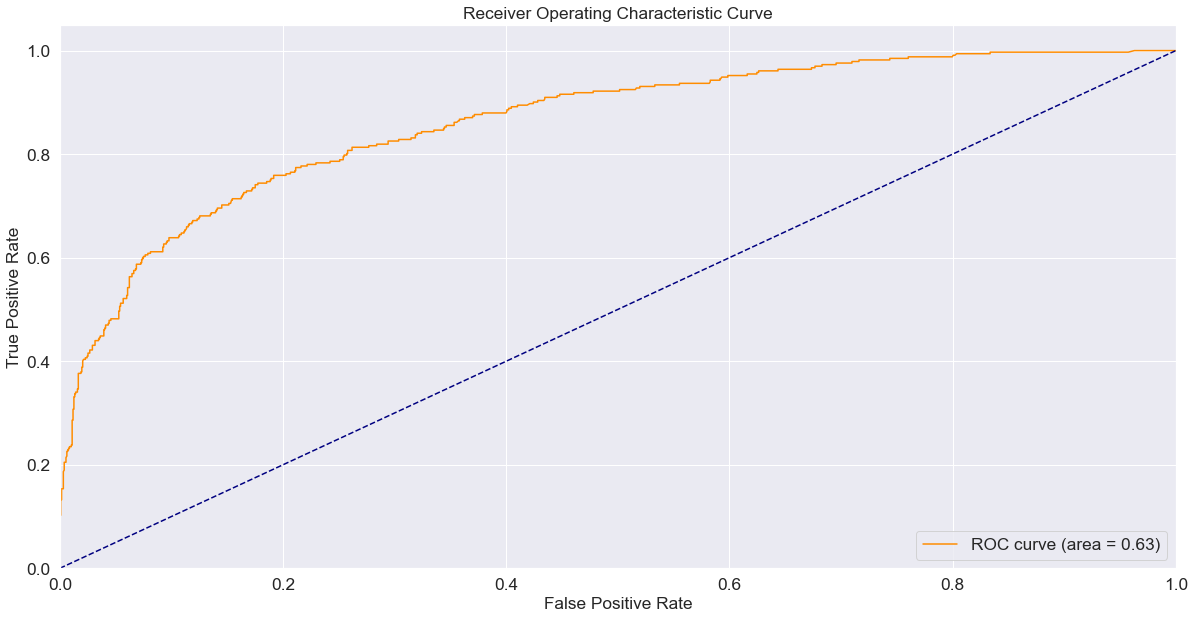

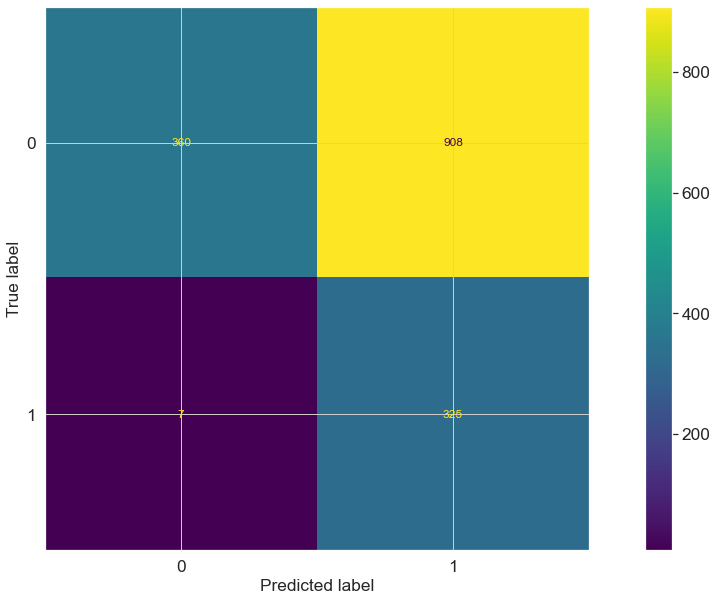

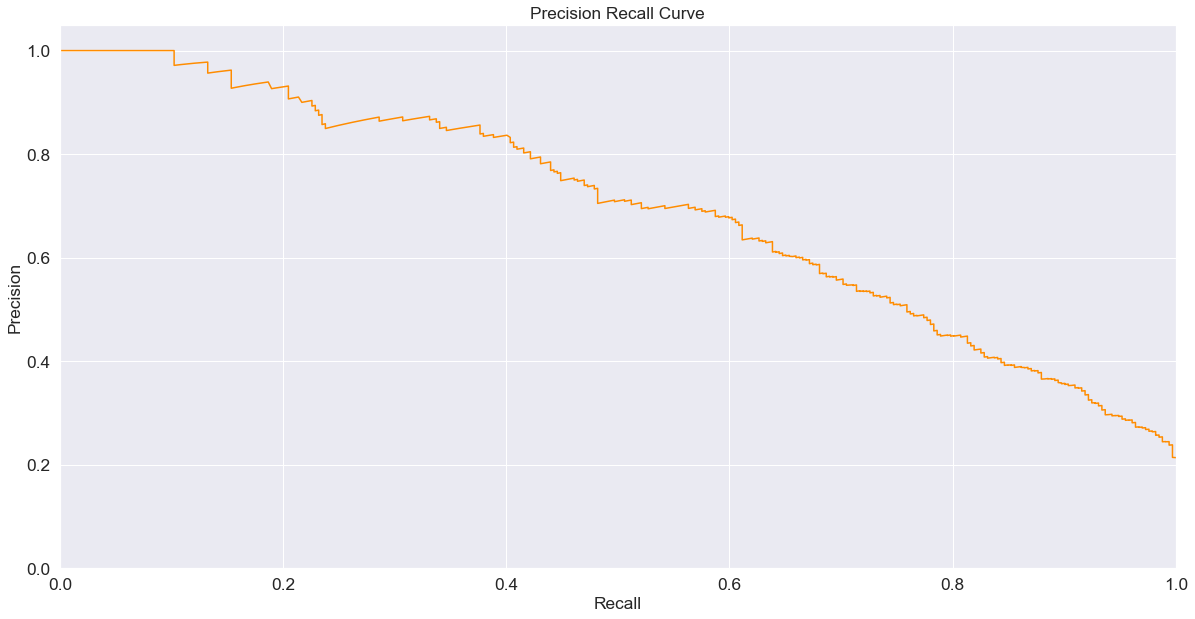

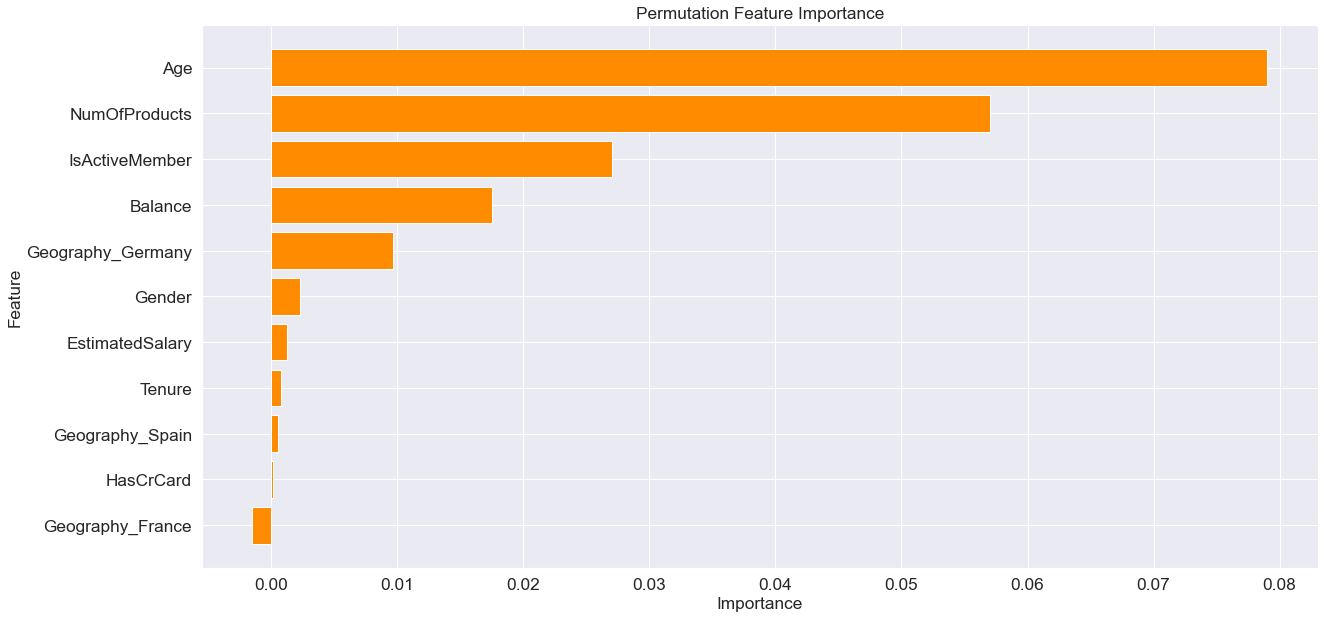

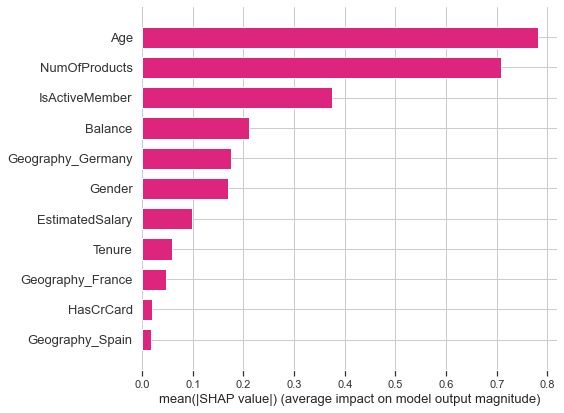

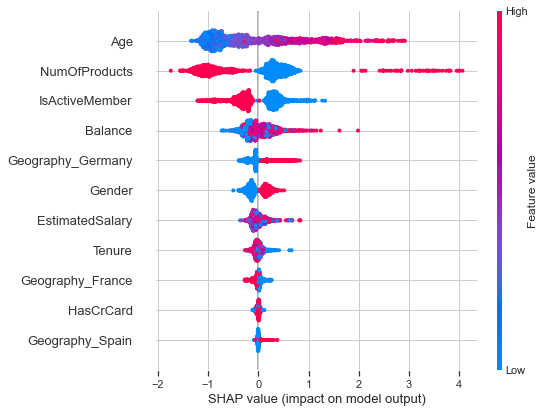

Running evaluation tests...


100%|██████████| 5/5 [00:00<00:00, 908.09it/s]


Model evaluation tests have completed.
Sending 5 test results to ValidMind...
Successfully logged test results for test: accuracy_score
Successfully logged test results for test: f1_score


Successfully logged test results for test: roc_auc_score
Successfully logged test results for test: training_better_than_test
Successfully logged test results for test: training_test_degradation

Summary of evaluation tests:

Test                       Scenario                              Results                                                                                                            Acceptable
-------------------------  ------------------------------------  -----------------------------------------------------------------------------------------------------------------  ------------
accuracy_score             Validation with default Test dataset  [('score', 0.428125), ('threshold', 0.7)]                                                                          False
f1_score                   Validation with default Test dataset  [('score', 0.41533546325878595), ('threshold', 0.5)]                                                               False
roc_auc_score     

In [18]:
eval_results = vm.evaluate_model(
    xgb_model,
    test_set=(x_test, y_test),
    train_set=(x_train, y_train),
    eval_opts={"decision_threshold": threshold}
)